# 02. Neural Network Classification with PyTorch

Classification is a problem of predicting whether somethign is one thing or another.

Book Version: https://www.learnpytorch.io/02_pytorch_classification/

All other resources: https://github.com/mrdbourke/pytorch-deep-learning

## 1. Make classification data and get it ready

In [1]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples, noise=0.03, random_state=42)
print(len(X), len(y))
print(f"\nFirst 5 samples of X: \n{X[:5]}")
print(f"First 5 samples of Y: {y[:5]}")

1000 1000

First 5 samples of X: 
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of Y: [1 1 1 1 0]


In [2]:
# Make DataFrame of circle data 
import pandas as pd

circles = pd.DataFrame({"X1": X[:, 0], 
                        "X2": X[:, 1],
                        "label": y})

circles.head(10)


,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


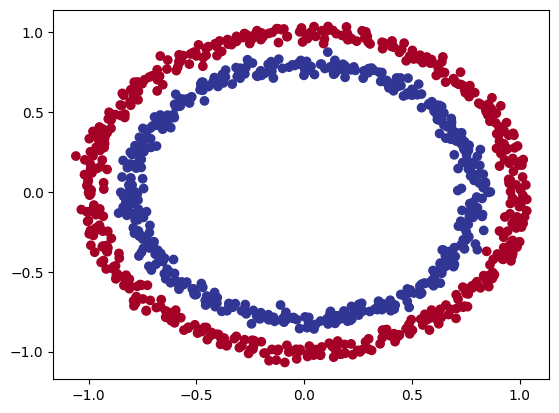

In [3]:
# Visualize
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)


**Note:** The data we're working with is often referred to as a toy dataset, a dataset that is small enough to experiment but still enough to practice the fundamentals

### 1.1 Check input and output shapes

In [4]:
X.shape, y.shape

((1000, 2), (1000,))

In [5]:
# View the first example of feature and labels
X_sample = X[0]
y_sample = y[0]


print(f"Values for one sample of X: {X_sample}, and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape}, and the same for y: {y_sample.shape}")
print(f"dtype of X: {X.dtype}, same goes for y: {y.dtype}")

Values for one sample of X: [0.75424625 0.23148074], and the same for y: 1
Shapes for one sample of X: (2,), and the same for y: ()
dtype of X: float64, same goes for y: int64


### 1.2 Turn data into tensors and create train and test splits


In [6]:
import torch
from sklearn.model_selection import train_test_split

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
print(f"New dtype of X: {X.dtype}, y: {y.dtype}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

New dtype of X: torch.float32, y: torch.float32
X shape: torch.Size([1000, 2])
y shape: torch.Size([1000])


## 2. Building a model

Let's build a model to classify our blue and red dots

To do so, we want to:
1. Setup device agnostic code so our code will run on an accelerator (GPU) if there is one.
2. Construct a model (by subclassing `nn.Module`).
3. Define a loss function and optimizer.
4. Create a training and test loop.

In [7]:
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"

X_train.to(device)
X_test.to(device)
y_train.to(device)
y_test.to(device)

tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0.,
        1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1.,
        1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
        1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0.,
        0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0.,
        1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0.,
        0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0.,
        1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
        0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1.,
        1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0.,
        0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0.,
        1., 1.])

Now we've setup device agnostic code, let's create a model that

1. Sublclasses `nn.Module` (alsmot all models in Pytorch subclass `nn.Module`)
2. Create 2 `nn.Linear()` layers that are capable of handling the shapes of our data
3. Define a `forward()` method that outlines the forward pass (or forward computation) of the model 
4. Instantiate an instance of our model class and send it to the target `device`

In [8]:
# 1. Construct a model that sublclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling the shapes of our data
        self.layer_1 = nn.Linear(in_features=2, out_features=5) 
        self.layer_2 = nn.Linear(in_features=5, out_features=2)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layer_2(self.layer_1(x))  # x -> layer_1 -> layer_2 -> output


model_0 = CircleModelV0()
model_0.to(device)
next(model_0.parameters()).device

device(type='cpu')

In [9]:
# Let's replicate the model above using nn.Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
)

model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.3918,  0.4059],
                      [ 0.6670, -0.3413],
                      [ 0.4101,  0.7047],
                      [-0.5146,  0.4943],
                      [ 0.1977,  0.6405]])),
             ('0.bias', tensor([-0.1619, -0.6450,  0.0549,  0.1417,  0.6111])),
             ('1.weight',
              tensor([[ 0.0048, -0.2544,  0.0091,  0.2470,  0.2453]])),
             ('1.bias', tensor([-0.3940]))])

In [10]:
# Make predictions
with torch.inference_mode():
    untrained_preds = model_0(X_test)
print(f"Length of prediction: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions: \n{untrained_preds[:10]}")
print(f"\nFirst 10 labels: \n{y_test[:10]}")

Length of prediction: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions: 
tensor([[ 0.3028],
        [ 0.3104],
        [ 0.0101],
        [ 0.3868],
        [-0.4229],
        [-0.4149],
        [-0.0504],
        [-0.2213],
        [ 0.0288],
        [ 0.3061]])

First 10 labels: 
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Setup loss function and optimizer

Which loss function or optimizer should you use?

Again... this is problem specific.

For example, for regression, you might want MAE or MSE

For classification, you might want binary cross entropy or categorical cross entropy

As a reminder, the loss function measures how  *wrong* your model's preditions are

And for optimizers, two of the most common and useful are SGD and Adam. However, PyTorch has many built-in options

- For the loss function, we're going to use `torch.nn.BCEWithLogitsLoss()`
    - For some common choices of loss functions and optimizers: https://www.learnpytorch.io/02_pytorch_classification/
    - For more on what binary cross entropy (BCE) is, check out this article: https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a/
    - For a definition of what a logit is in deep learning: https://stackoverflow.com/questions/41455101/what-is-the-meaning-of-the-word-logits-in-tensorflow/52111173#52111173
    - For different optimizers, see `torch.optim`

In [11]:
# Seteup the loss function

# loss_fn = nn.BCELoss()  # BCELoss = requires inputs to have gone through sigmoid activation function prior to input to BCE Loss
loss_fn = nn.BCEWithLogitsLoss()  # BCEWithLogitsLoss = sigmoid activation function built-in
optimizer = torch.optim.SGD(params=model_0.parameters(),
                        lr=0.15)
                        

In [12]:
# Calculate accuracy

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

## 3. Training the model

To train our model, we're going to need to build a training loop with the following steps:

1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss backward (backpropagation)
5. Optimizer step (gradient descent)

### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

Our model outputs are going to be raw **logits**.

We can convert these **logits** into **prediction probabilities** by passing them to some kind of activation function (e.g. sigmoid for binary classification and softmax for multiclass classification)

Then we can convert our model's predictions to **prediction labels** by either rounding them or taking the `argmax()`.

In [13]:
with torch.inference_mode():
    y_logits = model_0(X_test)[:5]
print(y_logits)

print("\nComparing the shapes")
print(y_logits.shape, y_test.shape)

tensor([[ 0.3028],
        [ 0.3104],
        [ 0.0101],
        [ 0.3868],
        [-0.4229]])

Comparing the shapes
torch.Size([5, 1]) torch.Size([200])


In [14]:
# Use the sigmoid activation functions on our logits
y_pred_probs = torch.sigmoid(y_logits)
print(y_pred_probs, "\n")

print(torch.round(y_pred_probs))

tensor([[0.5751],
        [0.5770],
        [0.5025],
        [0.5955],
        [0.3958]]) 

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [0.]])


For our predicition probability values, we need to perform a range-style roudning on them:

- `y_pred_prob` >= 0.5 = `y=1` (class 1)
- `y_pred_prob` < 0.5 = `y=0` (class 0)


In [15]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# In full (logits -> pred probs -> pred labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([1., 1., 1., 1., 0.])

In [16]:
## 3. Training the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000
epoch_count = []
train_loss_values = []
test_loss_values = []

for epoch in range(epochs):
    model_0.train()

    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))  # logits -> pred probs -> pred labels

    loss = loss_fn(y_logits, y_train)  # nn.BCEWithLogitsLoss expects raw logits as inputs
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    if epoch % 10 == 0:
        model_0.eval()
        with torch.inference_mode():
            test_logits = model_0(X_test).squeeze()
            test_pred = torch.round(torch.sigmoid(test_logits))

            test_loss = loss_fn(test_logits, y_test)
            test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

        print(f"Epoch: {epoch} | Train loss: {loss:.2f}, Accuracy {acc:.2f} | Test loss: {test_loss:.2f} | Test Accuracy: {test_acc:.2f}")
        epoch_count.append(epoch)
        train_loss_values.append(loss.detach().item())
        test_loss_values.append(test_loss.detach().item())
    

Epoch: 0 | Train loss: 0.70, Accuracy 49.50 | Test loss: 0.71 | Test Accuracy: 50.00
Epoch: 10 | Train loss: 0.70, Accuracy 49.00 | Test loss: 0.70 | Test Accuracy: 49.50
Epoch: 20 | Train loss: 0.70, Accuracy 49.25 | Test loss: 0.70 | Test Accuracy: 49.00
Epoch: 30 | Train loss: 0.70, Accuracy 49.00 | Test loss: 0.70 | Test Accuracy: 49.00
Epoch: 40 | Train loss: 0.69, Accuracy 49.88 | Test loss: 0.70 | Test Accuracy: 49.00
Epoch: 50 | Train loss: 0.69, Accuracy 49.50 | Test loss: 0.70 | Test Accuracy: 50.00
Epoch: 60 | Train loss: 0.69, Accuracy 49.88 | Test loss: 0.70 | Test Accuracy: 48.50
Epoch: 70 | Train loss: 0.69, Accuracy 49.75 | Test loss: 0.70 | Test Accuracy: 49.50
Epoch: 80 | Train loss: 0.69, Accuracy 49.88 | Test loss: 0.70 | Test Accuracy: 49.50
Epoch: 90 | Train loss: 0.69, Accuracy 50.00 | Test loss: 0.70 | Test Accuracy: 47.50
Epoch: 100 | Train loss: 0.69, Accuracy 50.75 | Test loss: 0.70 | Test Accuracy: 47.00
Epoch: 110 | Train loss: 0.69, Accuracy 50.50 | Test l

## 4. Make predictions and evaluate the model
 
From the metrics, it looks like our model isn't learning anything...

So, to inspect it, let's make some predictions and make them visual.

To do so, we're going to import a function called `plot_decision_boundary()`

In [17]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
    with open("helper_functions.py", "wb") as file:
        file.write(request.content)


helper_functions.py already exists


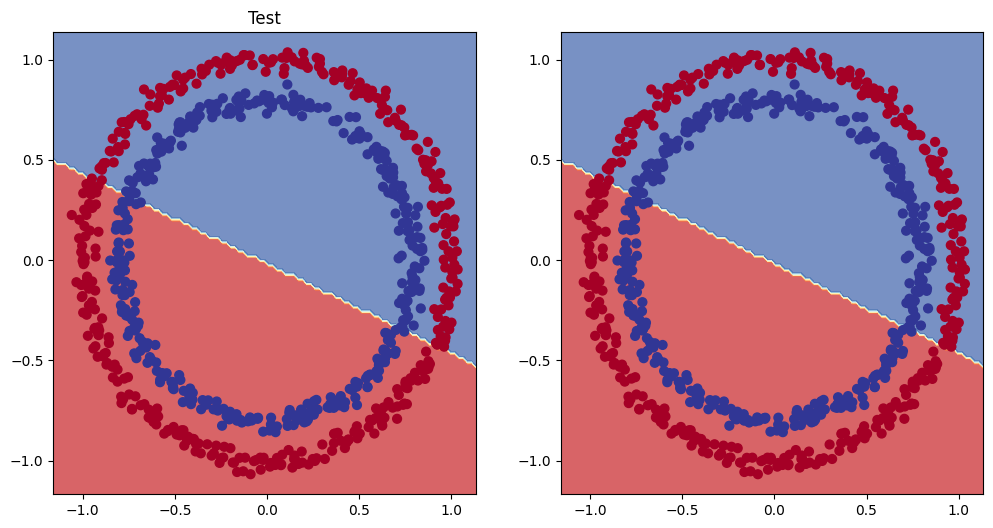

In [18]:
from helper_functions import plot_decision_boundary, plot_predictions

# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)

plt.title("Test")
plt.subplot(1, 2, 2)
plot_decision_boundary(model_0, X_train, y_train)


## 5. Improving a model (from a model perspective)

- Add more layers - give the model more chances to learn about patterns in the data
- Add more hidden units - go from 5 hidden units to 10 hidden units
- Fit for longer
- Changing the activation functions
- Change the learning rate
- Change the loss function

These options are all from a model's perspective because they deal directly with the model, rather thant the data

And becasue these options are all values we (as machine learning engineers and data scientists) can change,
they are referred to as **hyperparameters**

Let's try and improve our model by:
- Adding more hiddent units: 5 -> 10
- Increase the number of layers: 2 -> 3
- Increase the number of epochs: 100 -> 1000

In [19]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # z = self.layer_1(x)  # z is the convention for logits
        # z = self.layer_2(z)
        # z = self.layer_3(z)
        # return z
        return self.layer_3(self.layer_2(self.layer_1(x)))  # this way of writing operations leverages speed ups where possible behind the scenes
    

model_1 = CircleModelV1().to(device)

In [20]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                               lr=0.01)

In [21]:
# Training and Evaluation loop
torch.manual_seed(0)

epochs = 1000
for epoch in range(epochs):
    model_1.train()

    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_train, y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_pred)
    
    if epoch % 20 == 0:
        print(f"Epoch {epoch} | Train loss {loss:.2f}, Accuracy {acc:.2f} | Test loss {test_loss:.2f}, Test Accuracy {test_acc:.2f}")

Epoch 0 | Train loss 0.69, Accuracy 50.88 | Test loss 0.69, Test Accuracy 51.00
Epoch 20 | Train loss 0.69, Accuracy 50.62 | Test loss 0.69, Test Accuracy 50.50
Epoch 40 | Train loss 0.69, Accuracy 50.62 | Test loss 0.69, Test Accuracy 50.50
Epoch 60 | Train loss 0.69, Accuracy 50.62 | Test loss 0.69, Test Accuracy 51.00
Epoch 80 | Train loss 0.69, Accuracy 50.00 | Test loss 0.69, Test Accuracy 50.50
Epoch 100 | Train loss 0.69, Accuracy 50.25 | Test loss 0.69, Test Accuracy 50.00
Epoch 120 | Train loss 0.69, Accuracy 50.38 | Test loss 0.69, Test Accuracy 50.00
Epoch 140 | Train loss 0.69, Accuracy 50.12 | Test loss 0.69, Test Accuracy 50.50
Epoch 160 | Train loss 0.69, Accuracy 49.88 | Test loss 0.69, Test Accuracy 50.50
Epoch 180 | Train loss 0.69, Accuracy 50.12 | Test loss 0.69, Test Accuracy 50.00
Epoch 200 | Train loss 0.69, Accuracy 50.12 | Test loss 0.69, Test Accuracy 49.50
Epoch 220 | Train loss 0.69, Accuracy 50.12 | Test loss 0.69, Test Accuracy 49.50
Epoch 240 | Train loss

### 5.1 Preparing data to see if our model can fit a straight line

One way to troubleshoot a larger problem is to test out a smaller problem

In [22]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]


100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [23]:
train_split = int(0.8*len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

len(X_train_regression), len(X_test_regression), len(y_train_regression), len(y_test_regression)

(80, 20, 80, 20)

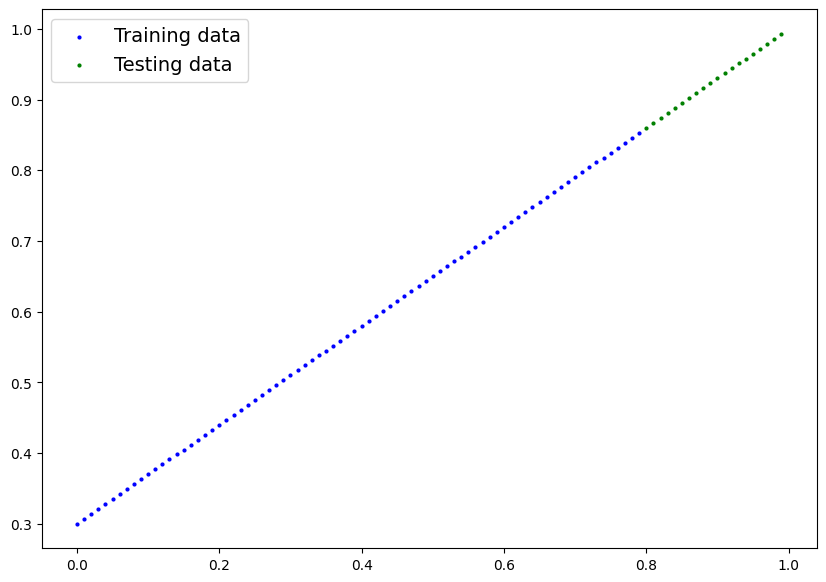

In [24]:
plot_predictions(train_data=X_train_regression, train_labels=y_train_regression,
                 test_data=X_test_regression, test_labels=y_test_regression)

In [25]:
### 5.2 Adjusting `model_1` to fit a straight line
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

In [26]:
# Loss function and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.1)

In [27]:
# Train the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
    model_2.train()

    y_pred = model_2(X_train_regression)
    loss = loss_fn(y_pred, y_train_regression)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_2.eval()
    with torch.inference_mode():
        test_pred = model_2(X_test_regression)
        test_loss = loss_fn(test_pred, y_test_regression)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss:.5f} | Test loss: {test_loss:.5f}")

Epoch: 0 | Train loss: 0.52008 | Test loss: 0.39976
Epoch: 10 | Train loss: 0.09645 | Test loss: 0.32581
Epoch: 20 | Train loss: 0.09866 | Test loss: 0.34313
Epoch: 30 | Train loss: 0.09688 | Test loss: 0.30865
Epoch: 40 | Train loss: 0.08316 | Test loss: 0.27161
Epoch: 50 | Train loss: 0.07734 | Test loss: 0.25266
Epoch: 60 | Train loss: 0.07498 | Test loss: 0.24729
Epoch: 70 | Train loss: 0.08401 | Test loss: 0.28161
Epoch: 80 | Train loss: 0.08178 | Test loss: 0.26994
Epoch: 90 | Train loss: 0.05629 | Test loss: 0.17600
Epoch: 100 | Train loss: 0.07891 | Test loss: 0.25709
Epoch: 110 | Train loss: 0.06384 | Test loss: 0.19277
Epoch: 120 | Train loss: 0.09208 | Test loss: 0.22667
Epoch: 130 | Train loss: 0.06630 | Test loss: 0.19883
Epoch: 140 | Train loss: 0.06438 | Test loss: 0.21137
Epoch: 150 | Train loss: 0.06013 | Test loss: 0.20185
Epoch: 160 | Train loss: 0.05935 | Test loss: 0.16887
Epoch: 170 | Train loss: 0.04825 | Test loss: 0.18455
Epoch: 180 | Train loss: 0.05453 | Test

## 6. The missing piece: non-linearity

"What patterns could you draw if you were given an infinite amount of straight and non-straight lines?"

Or in machine learning terms, an infinite (but really it is finite) of linear and non-linear functions?

### 6.1 Recreating non-linear data (red and blue circles)

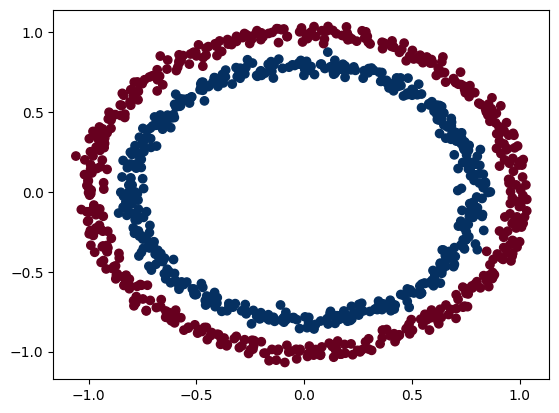

In [28]:
# Make and plot data
n_samples = 1000
X, y = make_circles(n_samples=n_samples,
                    noise=0.03,
                    random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu)

In [29]:
# Convert data to tensors and then to train and test splits 
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 6.2 Building a model with non-linearity

Artificial Neural Networks are a alarge combination of linear (straight) and non-straight (non-linear) functions which are potentially
able to find patterns in data

In [30]:
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=128)
        self.layer_2 = nn.Linear(in_features=128, out_features=128)
        self.layer_3 = nn.Linear(in_features=128, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
    
model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=128, bias=True)
  (layer_2): Linear(in_features=128, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

### 6.3 Training a model with non-linearity

In [31]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(),
                            lr=0.1)

epochs = 1000

for epoch in range(epochs):
    model_3.train()

    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_train, y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_3.eval()
    with torch.inference_mode():
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_pred)

    if epoch % 100 == 0:
        print(f"Epoch {epoch} | Train loss {loss:.5f}, Accuracy: {acc:.5f} | Test Loss {test_loss:.5f}, Test Accuracy: {test_acc:.5f}")



Epoch 0 | Train loss 0.69356, Accuracy: 50.00000 | Test Loss 0.69433, Test Accuracy: 50.00000
Epoch 100 | Train loss 0.66885, Accuracy: 79.37500 | Test Loss 0.67405, Test Accuracy: 79.00000
Epoch 200 | Train loss 0.61478, Accuracy: 97.12500 | Test Loss 0.62874, Test Accuracy: 91.50000
Epoch 300 | Train loss 0.48201, Accuracy: 99.00000 | Test Loss 0.51379, Test Accuracy: 98.00000
Epoch 400 | Train loss 0.28199, Accuracy: 99.62500 | Test Loss 0.32896, Test Accuracy: 99.00000
Epoch 500 | Train loss 0.15238, Accuracy: 100.00000 | Test Loss 0.19601, Test Accuracy: 100.00000
Epoch 600 | Train loss 0.08500, Accuracy: 100.00000 | Test Loss 0.12123, Test Accuracy: 100.00000
Epoch 700 | Train loss 0.05468, Accuracy: 100.00000 | Test Loss 0.08461, Test Accuracy: 100.00000
Epoch 800 | Train loss 0.03880, Accuracy: 100.00000 | Test Loss 0.06440, Test Accuracy: 100.00000
Epoch 900 | Train loss 0.02948, Accuracy: 100.00000 | Test Loss 0.05204, Test Accuracy: 100.00000


### 6.4 Evaluating the model trained with non-linear activation functions

In [32]:
# Make predictions
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()

y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

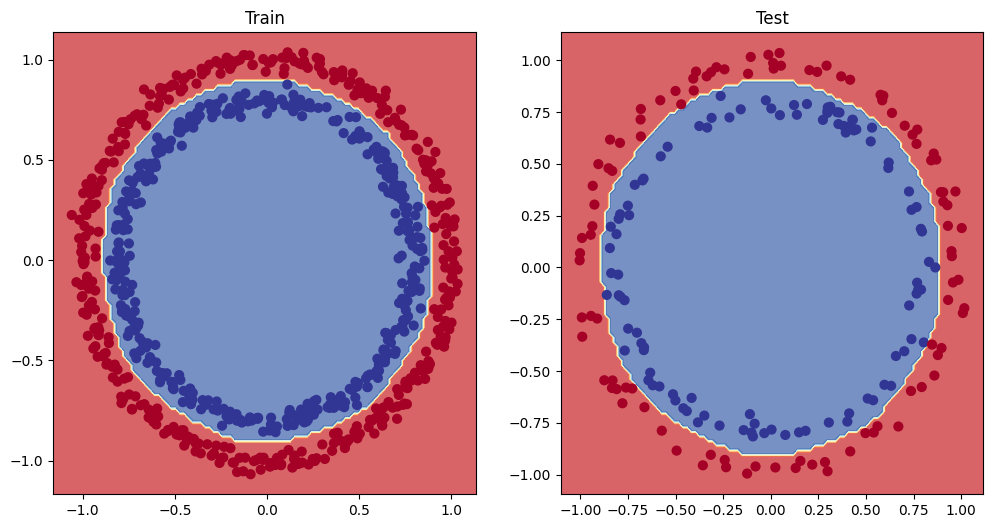

In [33]:
# Plot decision boundaries

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)



## 7. Replicating non-linear activation functions

Neural networks, rather than us telling the model what to learn, we give it the tools to discover patters in data and it tries to figure out the patterns on its own.

And these tools are linear and non-linear functions

In [34]:
# Create a tensor
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A.dtype, A

(torch.float32,
 tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
           2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.]))

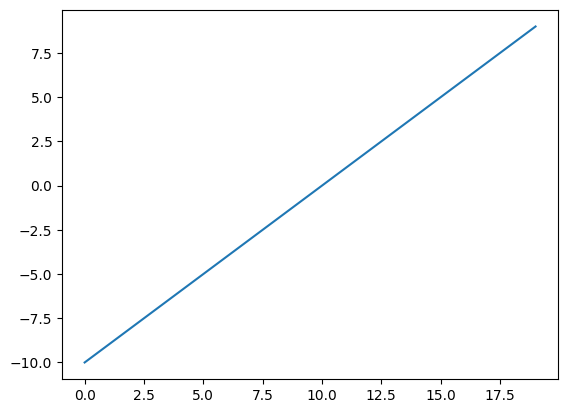

In [35]:
# Visualize the tensor
plt.plot(A)

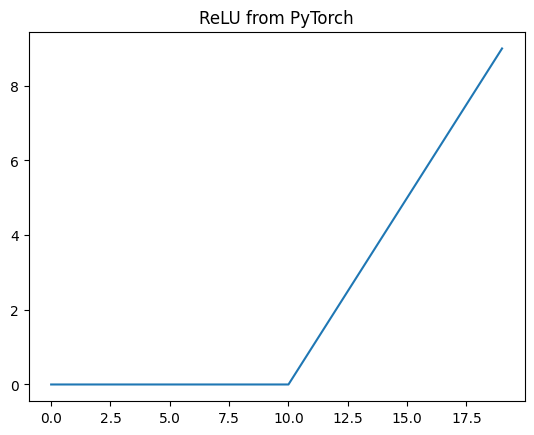

In [36]:
# PyTorch built-in relu
plt.title("ReLU from PyTorch")
plt.plot(torch.relu(A))

In [37]:
def relu(x: torch.Tensor) -> torch.Tensor:
    return torch.maximum(torch.tensor(0), x)  # inputs must be tensors 

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

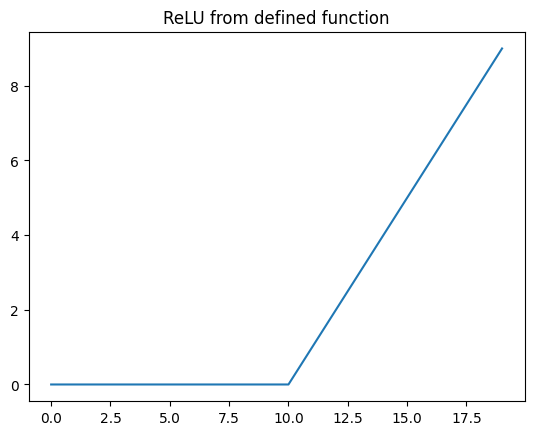

In [38]:
# Plot ReLU activation function
plt.title("ReLU from defined function")
plt.plot(relu(A))

In [39]:
# Now let's do the same for sigmoid (link: )

def sigmoid(x: torch.Tensor) -> torch.Tensor:
    return 1 / (1 + torch.exp(-x))


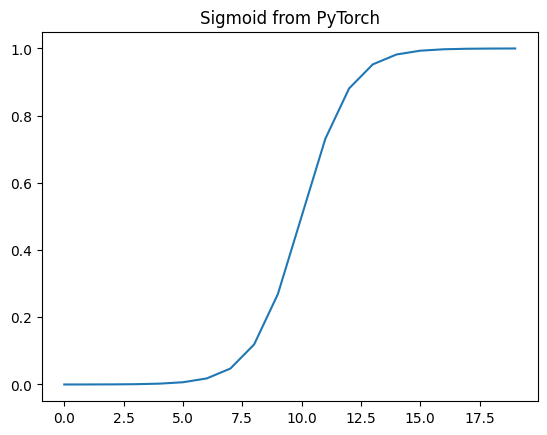

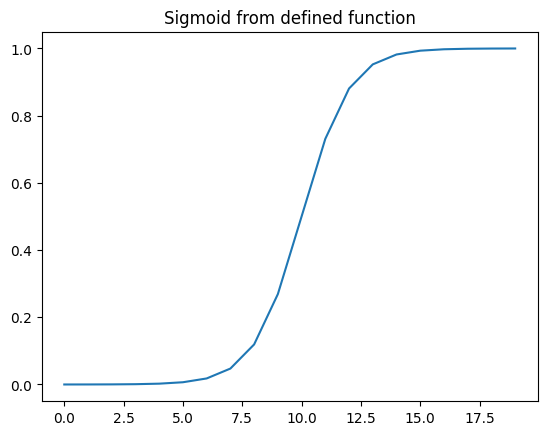

In [40]:
plt.title("Sigmoid from PyTorch")
plt.plot(torch.sigmoid(A))
plt.show()

plt.title("Sigmoid from defined function")
plt.plot(sigmoid(A))
plt.show()


## 8. Putting it all together with a multi-class classification problem

- Binary classification: one thing or another (cat vs dog, spam vs not spam)
- Multi-class classification: more than one thing or another (cat vs dog vs chicken)

### 8.1 Creating a toy multi-class dataset

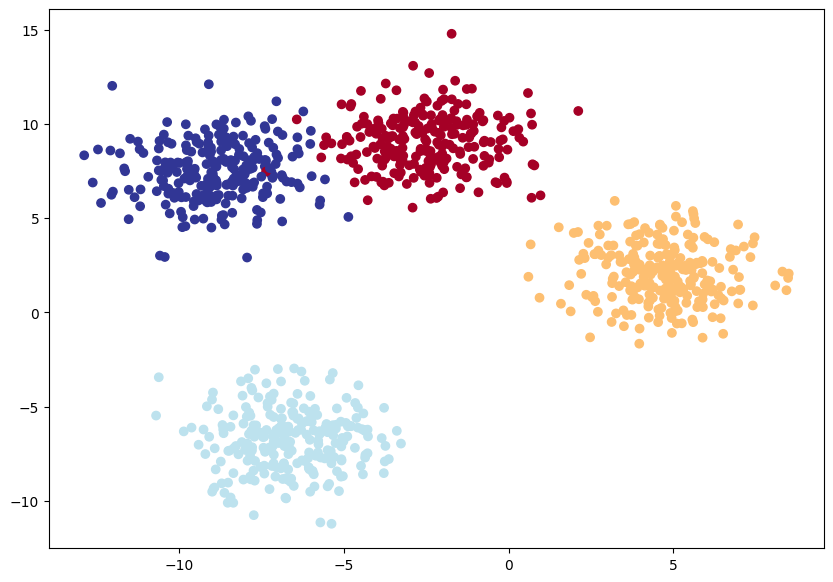

In [41]:
from sklearn.datasets import make_blobs

# Set the hyperparameters for data creation

RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=2,
                            centers=4,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)


# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Split into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

### 8.2 Building a multi-class classification model in PyTorch

In [42]:
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes multi-class classification model
        Args:
            input_features (int): Number of input features to the model
            output_features (int): Number of output features (number of classes)
            hidden_units (int): NUmber of hidden units between layers, default 8
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer_stack(x)

model_4 = BlobModel(input_features=2, output_features=4, hidden_units=8).to(device)

### 8.3 Loss function and optimizer

In [43]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr=0.01)



### 8.4 Getting prediction probabilities for a multiclass PyTorch model

In order to evaluate and train and test our model, we need to convert our model's outputs (logits) to predictions probabilities and then to prediction labels

Logits -> Pred Probs -> Pred labels

In [44]:
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_train)

y_logits[:10]

tensor([[-0.7586, -0.6810, -1.5180, -1.1178],
        [-0.2398, -1.2335, -0.9858, -0.2899],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [ 0.2391, -0.2472,  0.1494,  0.0213],
        [-0.1214, -0.9804, -0.6918, -0.1923],
        [-0.2044, -1.1380, -0.9468, -0.3093],
        [-0.2613, -1.2852, -1.0251, -0.2935],
        [-0.5237, -0.5791, -1.1276, -0.8689],
        [-0.0423, -0.8228, -0.4666, -0.0986],
        [-0.1876, -1.1245, -0.8498, -0.2406]])

In [45]:
# Convert our model's logit outputs to predictoin probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5], "\n")
print(y_pred_probs[:5])

tensor([[-0.7586, -0.6810, -1.5180, -1.1178],
        [-0.2398, -1.2335, -0.9858, -0.2899],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [ 0.2391, -0.2472,  0.1494,  0.0213],
        [-0.1214, -0.9804, -0.6918, -0.1923]]) 

tensor([[0.3080, 0.3328, 0.1441, 0.2150],
        [0.3577, 0.1324, 0.1696, 0.3402],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3000, 0.1845, 0.2743, 0.2413],
        [0.3424, 0.1450, 0.1936, 0.3190]])


In [46]:
print(torch.sum(y_pred_probs[0]))
print(torch.argmax(y_pred_probs[0]))

tensor(1.0000)
tensor(1)


In [47]:
# Convert our model's predictions probabilities to prediction labels
y_logits = torch.argmax(y_pred_probs, dim=1)
y_logits

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 3, 0, 0, 0, 0, 0,
        3, 0, 3, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 1, 1, 0, 0, 0, 1, 0, 3, 1, 0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 1, 0, 1,
        0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0,
        0, 0, 0, 3, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

### 8.5 Creating a training and testing loop

In [48]:
# Training the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)
 
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

epochs = 1000

for epoch in range(epochs):
    model_4.train()

    y_logits = model_4(X_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_blob_train, y_pred)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_4.eval()
    with torch.inference_mode():
        test_logits = model_4(X_blob_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_blob_test, test_pred)

    if epoch % 100 == 0:
        print(f"Epoch {epoch} | Train loss {loss:.5f}, Accuracy: {acc:.5f} | Test loss {test_loss:.5f}, Test Accuracy {test_acc:.5f}")


Epoch 0 | Train loss 1.15883, Accuracy: 40.37500 | Test loss 1.14724, Test Accuracy 38.50000
Epoch 100 | Train loss 0.64382, Accuracy: 96.87500 | Test loss 0.68117, Test Accuracy 97.00000
Epoch 200 | Train loss 0.41891, Accuracy: 98.62500 | Test loss 0.44228, Test Accuracy 100.00000
Epoch 300 | Train loss 0.23740, Accuracy: 99.25000 | Test loss 0.24455, Test Accuracy 99.50000
Epoch 400 | Train loss 0.10433, Accuracy: 99.25000 | Test loss 0.10148, Test Accuracy 99.50000
Epoch 500 | Train loss 0.06482, Accuracy: 99.25000 | Test loss 0.05914, Test Accuracy 99.50000
Epoch 600 | Train loss 0.05031, Accuracy: 99.25000 | Test loss 0.04355, Test Accuracy 99.50000
Epoch 700 | Train loss 0.04289, Accuracy: 99.25000 | Test loss 0.03538, Test Accuracy 99.50000
Epoch 800 | Train loss 0.03833, Accuracy: 99.25000 | Test loss 0.03022, Test Accuracy 99.50000
Epoch 900 | Train loss 0.03527, Accuracy: 99.25000 | Test loss 0.02690, Test Accuracy 99.50000


### 8.6 Making and evaluating predictions with a PyTorch multi-class model

In [49]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

print(f"Logits: \n{y_logits[:10]}\n")

y_pred_probs = torch.softmax(y_logits, dim=1)
print(f"Probabilities: \n{y_pred_probs[:10]}\n")

y_preds = y_pred_probs.argmax(dim=1)
print(f"Predictions: \n{y_preds[:10]}")

Logits: 
tensor([[-0.6780,  5.9374, -7.5888, -8.3576],
        [-2.1662, -6.3420, -3.7323,  3.1174],
        [-3.4562, -3.9502,  3.1581, -2.6437],
        [-1.1644,  4.1617, -3.8413, -4.8268],
        [ 3.7170, -1.3749, -9.0873, -6.8768],
        [-2.8119, -7.5421, -4.3044,  3.7828],
        [-3.0704, -3.3803,  2.7892, -2.1602],
        [ 3.3590, -4.0543, -6.8652, -3.5161],
        [-4.4254, -5.0603,  3.8233, -3.4248],
        [ 3.4808, -3.0514, -7.4990, -4.6582]])

Probabilities: 
tensor([[1.3378e-03, 9.9866e-01, 1.3337e-06, 6.1826e-07],
        [5.0431e-03, 7.7475e-05, 1.0533e-03, 9.9383e-01],
        [1.3341e-03, 8.1406e-04, 9.9485e-01, 3.0064e-03],
        [4.8373e-03, 9.9471e-01, 3.3269e-04, 1.2418e-04],
        [9.9386e-01, 6.1090e-03, 2.7321e-06, 2.4918e-05],
        [1.3653e-03, 1.2048e-05, 3.0692e-04, 9.9832e-01],
        [2.8183e-03, 2.0674e-03, 9.8811e-01, 7.0034e-03],
        [9.9833e-01, 6.0219e-04, 3.6223e-05, 1.0315e-03],
        [2.6129e-04, 1.3849e-04, 9.9889e-01, 7.10

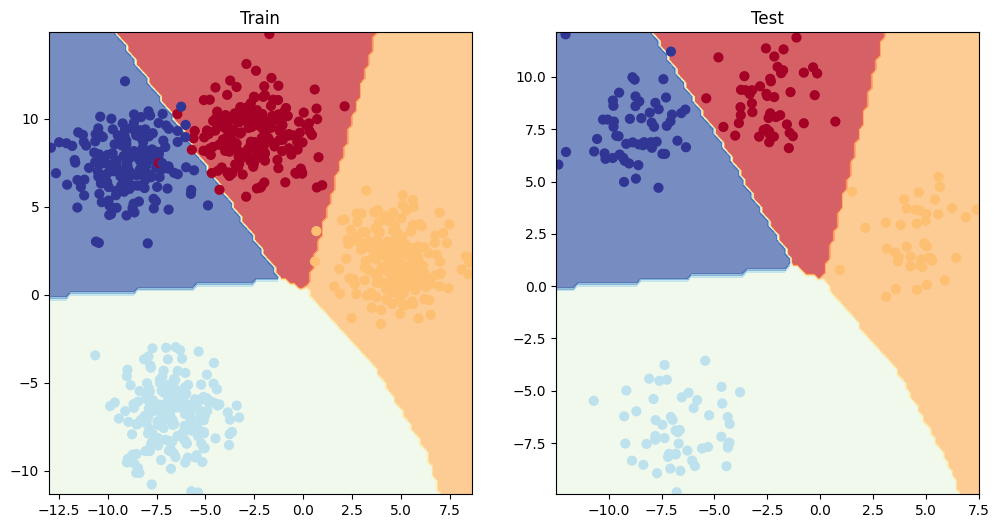

In [50]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

## 9. A few more classification metrics... (to evaluate our classification model)

- Accuracy: out of 100 samples, how many our models get right?
- Precision
- Recall
- F1-score
- Confusion Matrix
- Classification report

Article for when to use precision/recall: https://medium.com/data-science/beyond-accuracy-precision-and-recall-3da06bea9f6c

In [51]:
from torchmetrics import Accuracy

# Setup mterics

acc = Accuracy(task="multiclass", num_classes=4).to(device)
print(acc(y_preds, y_blob_test))

tensor(0.9950)
